Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


In [ ]:
# your code here

Performing k-means clustering with k=5 (standard way)

In [2]:
from sklearn.cluster import KMeans

# Fit k-means with k=5, multiple initializations for best inertia
model = KMeans(n_clusters=5, n_init=10, random_state=42).fit(X)

# Report smallest inertia
print(f"Smallest k-means inertia value: {model.inertia_}")

Smallest k-means inertia value: 924.3159961688092


2D visualization with PCA

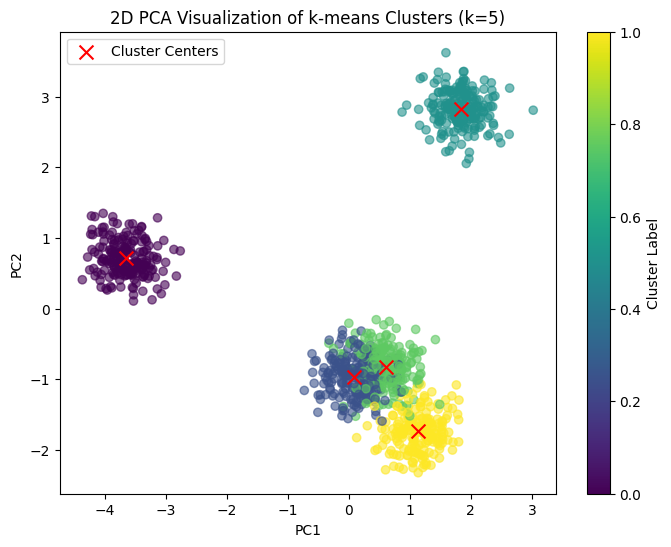

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(model.cluster_centers_)

# Plot clusters colored by labels, with centers marked
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model.labels_, cmap='viridis', alpha=0.6)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('2D PCA Visualization of k-means Clusters (k=5)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

Confusion matrix with label matching

In [6]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# Get predicted labels
y_pred = model.labels_

# Compute initial contingency matrix
contingency = confusion_matrix(y_true, y_pred)

# Use Hungarian algorithm to find optimal label matching (maximize alignment)
row_ind, col_ind = linear_sum_assignment(-contingency)  # Negate for maximization

# Create mapping from predicted to true labels
mapping = {i: col_ind[i] for i in range(5)}

# Remap predicted labels
y_pred_mapped = np.array([mapping[label] for label in y_pred])

# Compute confusion matrix with matched labels
conf_matrix = confusion_matrix(y_true, y_pred_mapped)

# Display confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[200   0   0   0   0]
 [  0 200   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 200   0]
 [  0   0   0   0 200]]


elbow analysis to justify k=5

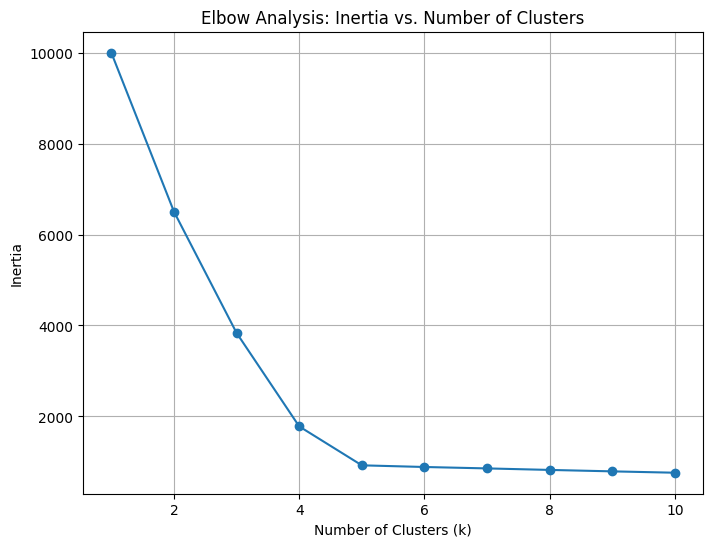

In [5]:
import matplotlib.pyplot as plt

# Compute inertias for k=1 to 10
inertias = []
for k in range(1, 11):
    m = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    inertias.append(m.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Analysis: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


In [ ]:
# your code here

Import additional libraries

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

creating 5:2 grid of distinct clothing images

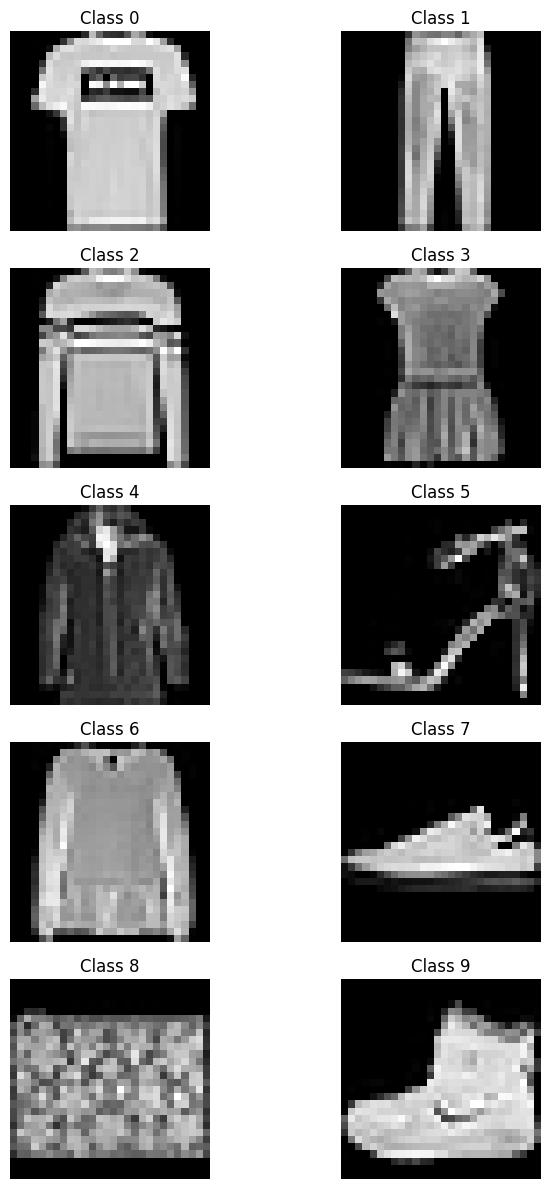

In [9]:
# Find one index per class (0-9)
class_indices = [np.where(y == i)[0][0] for i in range(10)]

# Plot 5x2 grid
fig, axs = plt.subplots(5, 2, figsize=(8, 12))
for i, idx in enumerate(class_indices):
    img = X[idx].reshape(28, 28)
    row, col = i // 2, i % 2
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(f'Class {i}')
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

scale data and reduce dimensions using PCA

In [10]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 50 dimensions with PCA for efficiency
pca_reduce = PCA(n_components=50, random_state=42)
X_reduced = pca_reduce.fit_transform(X_scaled)
print(f'Reduced shape: {X_reduced.shape}')

Reduced shape: (70000, 50)


k-means clustering for k=10

In [11]:
# Fit k-means
model = KMeans(n_clusters=10, n_init=10, random_state=42)
model.fit(X_reduced)

# Report inertia
print(f'Inertia: {model.inertia_}')

Inertia: 19610249.80942064


2D PCA visualization of clusters

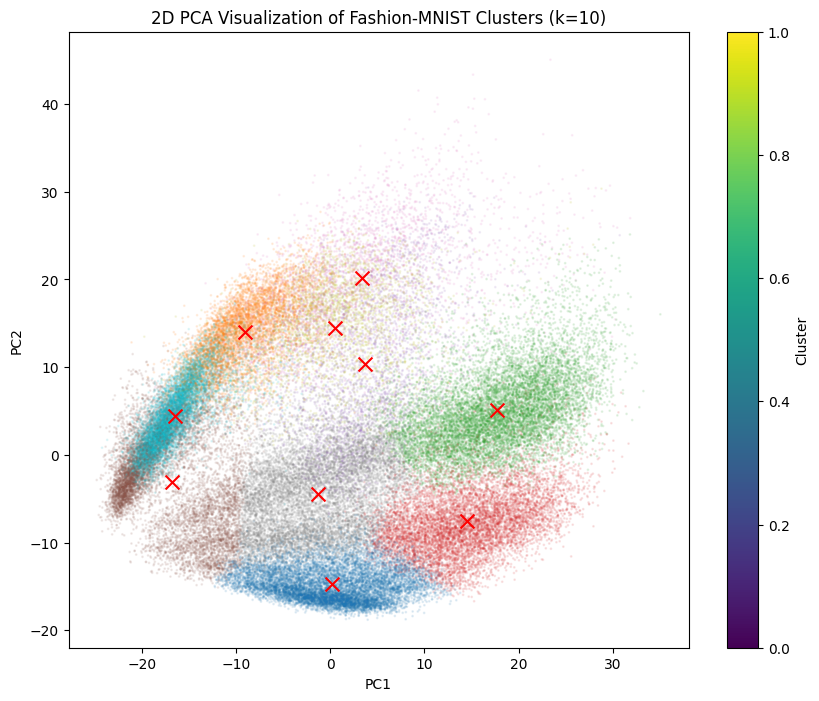

In [13]:
# Further reduce to 2D for visualization
pca_viz = PCA(n_components=2, random_state=42)
X_2d = pca_viz.fit_transform(X_scaled)  # Use scaled original for better viz

# Project centers back to original 784D approximation, then to 2D
centers_high_dim = pca_reduce.inverse_transform(model.cluster_centers_)
centers_2d = pca_viz.transform(centers_high_dim)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=model.labels_, cmap='tab10', alpha=0.1, s=1)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=100)
plt.title('2D PCA Visualization of Fashion-MNIST Clusters (k=10)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [14]:
# Predicted labels
y_pred = model.labels_

# Contingency matrix
contingency = confusion_matrix(y, y_pred)

# Hungarian algorithm for optimal matching
row_ind, col_ind = linear_sum_assignment(-contingency)

# Mapping
mapping = {i: col_ind[i] for i in range(10)}

# Remap predictions
y_pred_mapped = np.array([mapping[label] for label in y_pred])

# Final confusion matrix
conf_matrix = confusion_matrix(y, y_pred_mapped)
print('Confusion Matrix:\n', conf_matrix)

Confusion Matrix:
 [[   0    4   28  221    2  604  141   56 4021 1923]
 [   0    0    1 6313    0  170   65    5  261  185]
 [   1    4   71   13    1  555 4085   33  155 2082]
 [   1    0    4 3724    0  580   48    1 1865  777]
 [   0    0   58  211    0  296 4118    7 1061 1249]
 [ 481 1599   12    2  289 4569    0    0    1   47]
 [   2    8   40   70    3  874 2176  101 1289 2437]
 [ 756 5595    0    0   17  632    0    0    0    0]
 [ 168  351 2693   24   27  461  166 2475   47  588]
 [4063  284    0    4 2381  195    3    1    9   60]]


elbow analysis

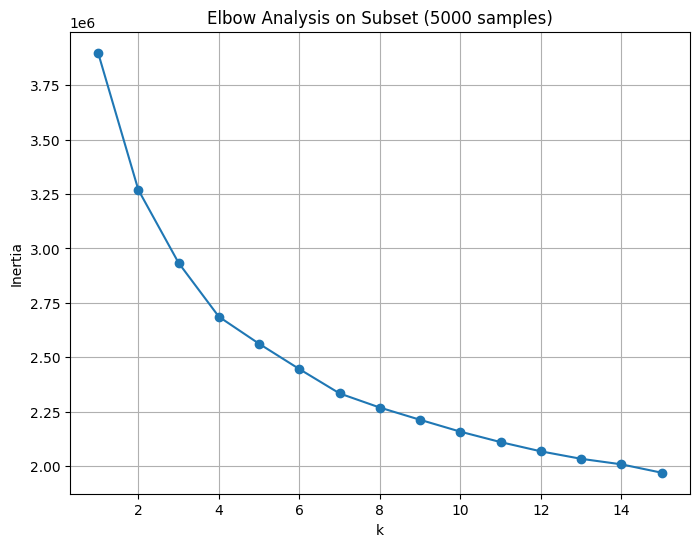

In [15]:
# Sample 5000 for efficiency
np.random.seed(42)
subset_indices = np.random.choice(len(X_scaled), 5000, replace=False)
X_subset = X_scaled[subset_indices]

# Compute inertias for k=1 to 15
inertias = []
for k in range(1, 16):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_subset)
    inertias.append(km.inertia_)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), inertias, marker='o')
plt.title('Elbow Analysis on Subset (5000 samples)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

In [ ]:
# your code here

# 4. Clustering Fashion-MNIST using spectral clustering

In [ ]:
# your code here